In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
family = pd.DataFrame(pd.read_csv("./station_day.csv"))
family = family.dropna()
family.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate
5,AP001,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,109.74,0.21,4.71,0.08,173.0,Moderate


In [6]:
family.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000
mean,52.482100,108.494813,12.204897,33.188329,29.911210,17.099812,0.699242,9.907130,32.224498,4.429789,12.120517,2.862333,119.847004
std,43.101142,67.881316,18.880759,22.909939,28.188032,12.737291,0.436917,7.926233,19.937162,13.419295,23.774658,7.048609,75.075472
min,1.090000,5.770000,0.020000,0.010000,0.020000,0.100000,0.000000,0.100000,0.030000,0.000000,0.000000,0.000000,16.000000
25%,25.740000,62.692500,2.650000,15.220000,12.680000,9.332500,0.420000,4.370000,18.380000,0.230000,1.390000,0.120000,72.000000
50%,43.400000,98.805000,6.270000,28.570000,22.500000,13.850000,0.630000,7.860000,28.240000,1.520000,5.010000,0.880000,104.000000
75%,66.210000,137.837500,13.430000,46.170000,36.675000,21.970000,0.900000,12.810000,41.410000,4.160000,12.467500,2.950000,139.000000
max,734.560000,830.100000,262.000000,254.780000,331.500000,269.930000,4.740000,67.260000,162.330000,165.410000,259.030000,133.600000,692.000000


In [7]:
compositional_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

family = family[['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']]
total_household_income = family['AQI']
#family = family[(family != 0).all(axis=1)]

# Tách dữ liệu thành phần và biến mục tiêu
compositional_data = family[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
1,0.203576,0.311367,0.003601,0.051269,0.030211,0.026810,0.000300,0.038114,0.317844,0.000500,0.016256,0.000150
2,0.189839,0.312827,0.003054,0.063021,0.035995,0.024918,0.000339,0.065348,0.284662,0.000533,0.019270,0.000194
3,0.197350,0.300872,0.014674,0.068592,0.048404,0.028704,0.000245,0.074684,0.248599,0.000645,0.016965,0.000267
4,0.164623,0.266993,0.006566,0.072000,0.043631,0.029293,0.000231,0.048735,0.354435,0.000436,0.012876,0.000180
5,0.195849,0.310353,0.014134,0.062698,0.044834,0.033105,0.000432,0.028511,0.296571,0.000568,0.012729,0.000216


In [8]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(compositional_data, total_household_income, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                    AQI   No. Observations:                 8251
Model:                            RLM   Df Residuals:                     8238
Method:                          IRLS   Df Model:                           12
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 01 Jun 2024                                         
Time:                        12:37:39                                         
No. Iterations:                    26                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.0602      0.486    232.536      0.0

In [9]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 56.326331845935776


In [10]:
# Độ lệch chuẩn của Total.Household.Income
std_income = np.std(y_test)
print(f"Standard Deviation of Total Household Income: {std_income}")

Standard Deviation of Total Household Income: 73.2071037656075


/tmp/ipykernel_1729/12606955.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')


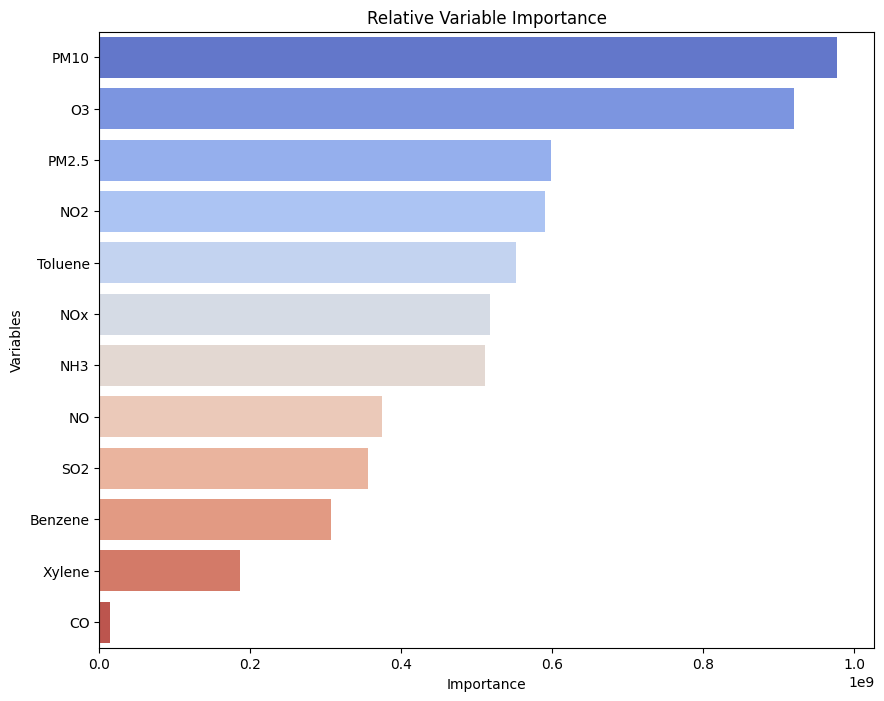

In [11]:
# Vẽ biểu đồ tầm quan trọng của biến
importance = rlm_results.params[1:]
variables = X_train.columns

importance_df = pd.DataFrame({
    'Variables': variables,
    'Importance': np.abs(importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')
plt.title('Relative Variable Importance')
plt.show()


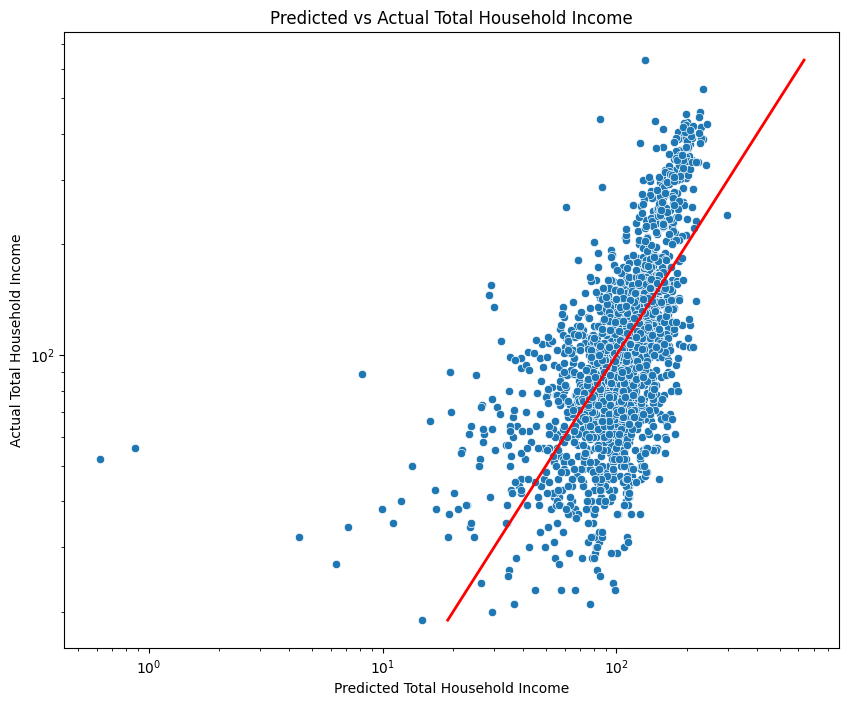

In [12]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()